<a href="https://colab.research.google.com/github/krawch1989/iowa_liquor_sales/blob/master/main_iowa_liquor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
import folium
from folium import plugins

%matplotlib inline

In [0]:
eth_project_id = 'earnest-star-194115'
client = bigquery.Client(project=eth_project_id)

In [0]:
# Будем анализировать данные за 19-й год
sql = """
    SELECT *
    FROM `bigquery-public-data.iowa_liquor_sales.sales`
    where date BETWEEN DATE('2019-01-01') AND DATE('2019-12-31')
"""

df = client.query(sql).to_dataframe()

In [4]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-23523500115,2019-11-26,2621,Hy-Vee Food Store #3 / Sioux City,3301 Gordon Dr,Sioux City,51105,POINT (-96.364108 42.487752),97,WOODBURY,1062100,Gold Rum,434,LUXCO INC,45248,Paramount Gold Rum,6,1750,7.84,11.76,12,141.12,21.00,5.54
1,INV-23553700006,2019-11-29,2636,Hy-Vee Wine and Spirits / Hubbell,2310 Hubbell Ave,Des Moines,50317,POINT (-93.573845 41.604312),77,POLK,1081100,Coffee Liqueurs,370,PERNOD RICARD USA,67522,Kahlua Coffee Mini,12,50,6.60,9.90,1,9.90,0.05,0.01
2,INV-19815000029,2019-06-05,5257,MAD Ave Quik Shop,"405, Madison Ave",Ottumwa,52501,None,90,WAPELLO,1041300,American Sloe Gins,434,LUXCO INC,33717,Paramount Sloe Gin,12,1000,5.42,8.13,2,16.26,2.00,0.52
3,INV-20031500098,2019-06-17,4167,"Iowa Street Market, Inc.",1256 Iowa St,Dubuque,52001,POINT (-90.668138 42.504959),31,DUBUQUE,1042100,Imported Dry Gins,260,DIAGEO AMERICAS,28867,Tanqueray Gin,12,1000,15.50,23.25,4,93.00,4.00,1.05
4,INV-17159700003,2019-01-25,4650,Loofts on 9 Liquor Here or Liquor There,"202, W 4th Ave",Swea City,50590,POINT (-94.30874900000002 43.38496),55,KOSSUTH,1081100,Coffee Liqueurs,065,Jim Beam Brands,67557,Kamora Coffee Liqueur,12,1000,8.39,12.59,4,50.36,4.00,1.05


In [5]:
df.dtypes

invoice_and_item_number     object
date                        object
store_number                object
store_name                  object
address                     object
city                        object
zip_code                    object
store_location              object
county_number               object
county                      object
category                    object
category_name               object
vendor_number               object
vendor_name                 object
item_number                 object
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtype: object

In [0]:
# Извлечем фичи з даты
df.date = pd.to_datetime(df.date)
df['dayofweek'] = df.date.dt.weekday_name
df['month'] = df.date.dt.month_name()
df.loc[df.month.isin(['December','January','February']),'season'] = 'winter'
df.loc[df.month.isin(['March','April','May']),'season'] = 'spring'
df.loc[df.month.isin(['June','July','August']),'season'] = 'summer'
df.loc[df.month.isin(['September','October','November']),'season'] = 'autumn'

In [7]:
# Найдем пропорцию магазинов в которых не указаны гео координаты
df.store_location = df.store_location.str.replace('POINT \(', '').str.replace(')', '').str.strip().str.split(' ')
len(df.loc[df.store_location.isnull()])/len(df)

0.09216731188126091

In [0]:
# Извлечем широту и долготу 
df.loc[df.store_location.notnull(), 'longtitude'] = df.loc[df.store_location.notnull(), 'store_location'].apply(lambda x: x[0]).astype(float).round(4)
df.loc[df.store_location.notnull(), 'latitude'] = df.loc[df.store_location.notnull(), 'store_location'].apply(lambda x: x[1]).astype(float).round(4)

На примере переменной vendor можно увидеть что у одного id может быть несколько name (названий). Тут у 191 id соответствует 192 name. Приведем такие категории в формат 1 id - 1 name.

In [9]:
df.vendor_number.value_counts()

260    387247
065    215190
421    201695
434    189225
370    136899
        ...  
591         1
560         1
506         1
600         1
622         1
Name: vendor_number, Length: 191, dtype: int64

In [10]:
df.vendor_name.value_counts()

DIAGEO AMERICAS                      387247
Jim Beam Brands                      215190
SAZERAC COMPANY  INC                 201695
LUXCO INC                            189225
PERNOD RICARD USA                    136899
                                      ...  
HPSepicurean LLC / Preiss Imports         1
Tierra Madre LLC                          1
Heavenly Spirits LLC                      1
St. Louis Distillery LLC                  1
Doc Brown Enterprises                     1
Name: vendor_name, Length: 192, dtype: int64

In [11]:
cat_number = ['store_number','county_number','category','vendor_number'] 
cat_name = ['store_name','county','category_name','vendor_name']
for number, name in zip(cat_number, cat_name):
  print(number,name)
  frame = df[[number, name]].drop_duplicates(subset = number)
  del df[name]
  df = df.merge(frame, how='left', on=number)
  del df[number]
del frame

store_number store_name
county_number county
category category_name
vendor_number vendor_name


In [0]:
# Удалим ненужние переменные которые мы точно не будем анализировать
df = df.drop(columns=['address', 'store_location'])

In [13]:
# Визуализируем наши покупки на карте. В colab и jupyter больше 50 тис точек не отобразиться.
# Поэтому я взял sample 50000. Но если сохранить карту как html страницу, то можна указать все точки.
m = folium.Map([42.21, -93.60], zoom_start=8)
# convert to (n, 2) nd-array format for heatmap
stationArr = df.loc[df["latitude"].notnull() & df["longtitude"].notnull(),['latitude', 'longtitude']].sample(50000).as_matrix()
# plot heatmap
m.add_children(plugins.HeatMap(stationArr, radius=15))
m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  """


In [14]:
# Посмотрим как корелируют наши числовые переменные
corr = df[['pack','bottle_volume_ml','state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters','volume_sold_gallons']].corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Corr beetween numerical vars")\
    .set_precision(4)\
    .set_table_styles(magnify())

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
pack,1,-0.5666,-0.3626,-0.3626,0.1788,-0.04806,-0.05164,-0.05166
bottle_volume_ml,-0.5666,1,0.2611,0.2611,-0.03168,0.07875,0.1339,0.134
state_bottle_cost,-0.3626,0.2611,1,0.9998,-0.07031,0.1157,0.006553,0.006553
state_bottle_retail,-0.3626,0.2611,0.9998,1,-0.07029,0.1157,0.006555,0.006555
bottles_sold,0.1788,-0.03168,-0.07031,-0.07029,1,0.8025,0.8496,0.8496
sale_dollars,-0.04806,0.07875,0.1157,0.1157,0.8025,1,0.8376,0.8376
volume_sold_liters,-0.05164,0.1339,0.006553,0.006555,0.8496,0.8376,1,1
volume_sold_gallons,-0.05166,0.134,0.006553,0.006555,0.8496,0.8376,1,1


In [0]:
# Так как объем в литрах и галонах это фактически одно и то же. Оставим более удобные для восприятия литры.
del df['volume_sold_gallons']

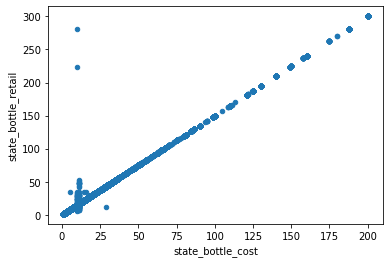

In [16]:
# Очень сильно коррелируют закупочные цены с теми что в ритейле. И у всех соотношение state_bottle_retail/state_bottle_cost
# равняеться 1.5. Но на графике есть точки которые выпадают из этого тренда. Посмотрим на них внимательнее
df[df.state_bottle_cost <= 200].plot(kind = "scatter",x="state_bottle_cost",y = "state_bottle_retail")
plt.show()

In [17]:
# В таблице мы видим что в данных ошибка. За 6 бутылок было заплачено 90 доларов, а цена за одну указана 223.5 и 281.25.
# Если поделить 90 на 6 то получиться 15 доларов за бутылку (при закупке 10 доларов), что соответствует тренду.
# При построении модели такие ошибки нужно будет найти и исправить
df[(df.state_bottle_retail/df.state_bottle_cost) > 5]

,invoice_and_item_number,date,city,zip_code,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,dayofweek,month,season,longtitude,latitude,store_name,county,category_name,vendor_name
172861,INV-22918500001,2019-10-30,Spirit Lake,51360,100762,Bird Dog Peach w/2-50mls,6,850,10.00,223.50,6,90.00,5.10,Wednesday,October,autumn,-95.1268,43.4164,Forbes Liquor Locker / remi,DICKINSON,Temporary & Specialty Packages,WESTERN SPIRITS BEVERAGE
172972,INV-22865900004,2019-10-29,Marshalltown,50158,100762,Bird Dog Peach w/2-50mls,6,850,10.00,281.25,6,90.00,5.10,Tuesday,October,autumn,-92.9080,42.0500,Marshall Beer Wine Spirits,MARSHALL,Temporary & Specialty Packages,WESTERN SPIRITS BEVERAGE
454669,INV-22117900032,2019-09-24,Altoona,50009,100040,Grand Marnier w/2 Shot Glasses,6,750,5.23,34.97,1,34.97,0.75,Tuesday,September,autumn,-93.4946,41.6585,Super Stop 2 / Altoona,POLK,Imported Cordials & Liqueur,Skyy Spirits Inc


In [0]:
df.loc[(df.state_bottle_retail/df.state_bottle_cost) > 5, 'state_bottle_retail'] = df.loc[(df.state_bottle_retail/df.state_bottle_cost) > 5, 
                'sale_dollars']/df.loc[(df.state_bottle_retail/df.state_bottle_cost) > 5, 'bottles_sold']

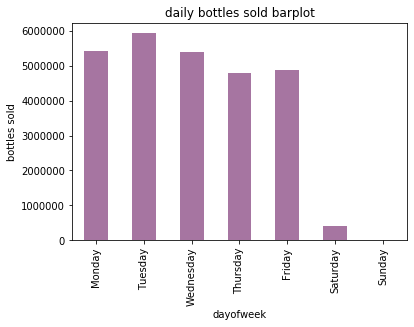

In [32]:
# Проанализируем количество проданых бутылок по дням/месяцам/сезонам.
# Обычно закупки проводяться в начале недели. На выходных количество закупок минимально
df[['dayofweek','bottles_sold']].groupby(['dayofweek'], 
  as_index=True)['bottles_sold'].sum()[['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].plot(kind='bar', color='#a675a1')
plt.title('daily bottles sold barplot');
plt.ylabel('bottles sold');

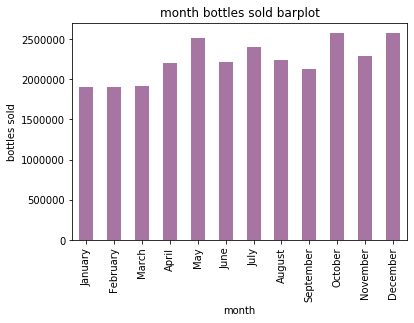

In [19]:
# Первые три месяца в году у продавцов алкоголя в Айове "низкий сезон".
df[['month','bottles_sold']].groupby(['month'], 
  as_index=True)['bottles_sold'].sum()[['January', 'February','March','April',
                                        'May','June','July','August','September','October','November','December']].plot(kind='bar', color='#a675a1')
plt.title('month bottles sold barplot');
plt.ylabel('bottles sold');

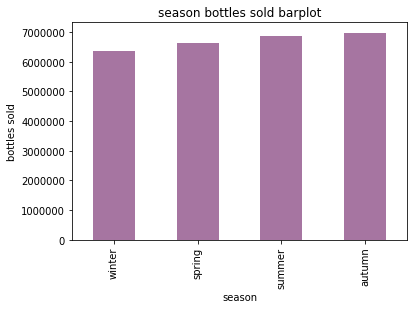

In [20]:
df[['season','bottles_sold']].groupby(['season'], 
  as_index=True)['bottles_sold'].sum()[['winter', 'spring','summer','autumn']].plot(kind='bar', color='#a675a1')
plt.title('season bottles sold barplot');
plt.ylabel('bottles sold');

# Top 10

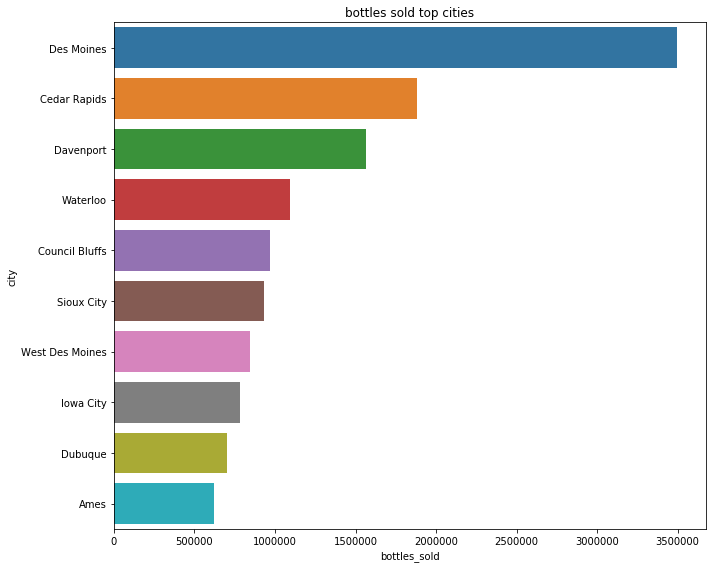

In [21]:
# Самые пьющие города в Айове. По количеству купленых бутылок в году.
# Думаю тут коректнее анализировать количество бутылок на одного жителя. 
# Но поскольку у меня нету данных по количеству жителей, то пускай будет так.
cats = df[["city", "bottles_sold"]].groupby("city").sum().sort_values(by="bottles_sold", ascending=False)[:10].reset_index()
plt.figure(figsize=(10,8))
sns.barplot(x="bottles_sold", y="city", data=cats)
plt.title('bottles sold top cities')
plt.tight_layout()

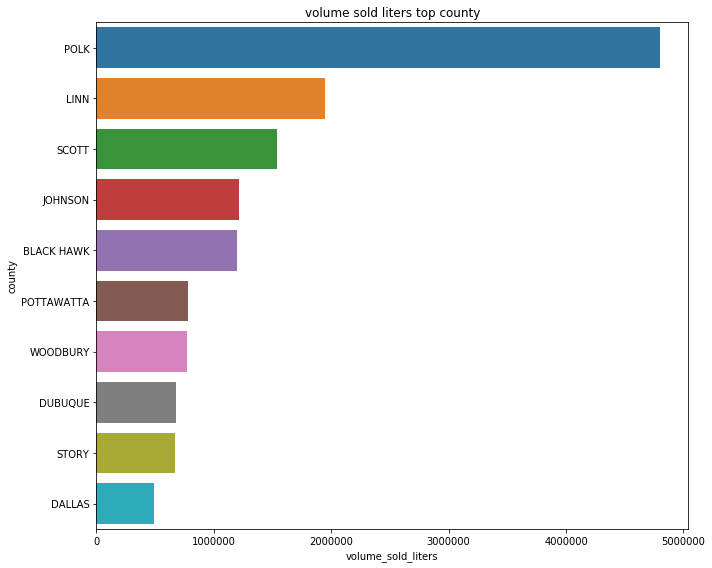

In [22]:
# Количество купленого алкоголя по округам. Тоже Топ 10. Что-то мне кажеться что Polk самый населенные округ в Айове.
cats = df[["county", "volume_sold_liters"]].groupby("county").sum().sort_values(by="volume_sold_liters", ascending=False)[:10].reset_index()
plt.figure(figsize=(10,8))
sns.barplot(x="volume_sold_liters", y="county", data=cats)
plt.title('volume sold liters top county')
plt.tight_layout()

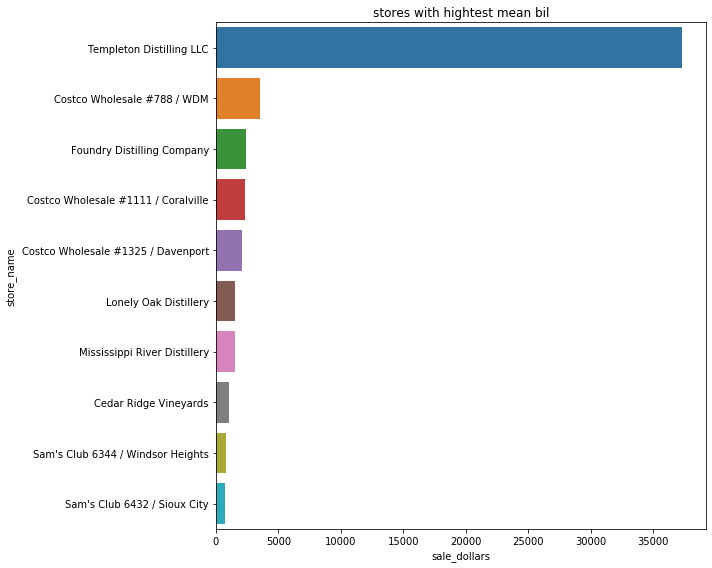

In [24]:
# Магазины с самым высоким средним чеком. Тут у нас есть магазин, который явный лидер. Посмотрю на него детальнее.
cats = df[["store_name", "sale_dollars"]].groupby("store_name").mean().sort_values(by="sale_dollars", ascending=False)[:10].reset_index()
plt.figure(figsize=(10,8))
sns.barplot(x="sale_dollars", y="store_name", data=cats)
plt.title('stores with hightest mean bil')
plt.tight_layout()

In [26]:
# У магазина только 4 закупки, но каких. До 1200 едениц алкоголя одной и той же марки за раз.
df[df.store_name == 'Templeton Distilling LLC']

,invoice_and_item_number,date,city,zip_code,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,dayofweek,month,season,longtitude,latitude,store_name,county,category_name,vendor_name
170389,INV-24266500001,2019-12-31,Templeton,51463,926875,Templeton Rye Special Reserve 6YR,6,750,25.13,37.7,360,13572.0,270.0,Tuesday,December,winter,-94.9364,41.9171,Templeton Distilling LLC,CARROLL,Blended Whiskies,Templeton Distilling LLC
284623,INV-21400200001,2019-08-22,Templeton,51463,926875,Templeton Rye Special Reserve 6YR,6,750,25.13,37.7,1200,45240.0,900.0,Thursday,August,summer,-94.9364,41.9171,Templeton Distilling LLC,CARROLL,Blended Whiskies,Templeton Distilling LLC
284782,INV-17162400001,2019-01-25,Templeton,51463,926875,Templeton Rye Special Reserve 6YR,6,750,25.13,37.7,1200,45240.0,900.0,Friday,January,winter,-94.9364,41.9171,Templeton Distilling LLC,CARROLL,Blended Whiskies,Templeton Distilling LLC
398677,INV-19710400001,2019-05-31,Templeton,51463,926875,Templeton Rye Special Reserve 6YR,6,750,25.13,37.7,1200,45240.0,900.0,Friday,May,spring,-94.9364,41.9171,Templeton Distilling LLC,CARROLL,Blended Whiskies,Templeton Distilling LLC


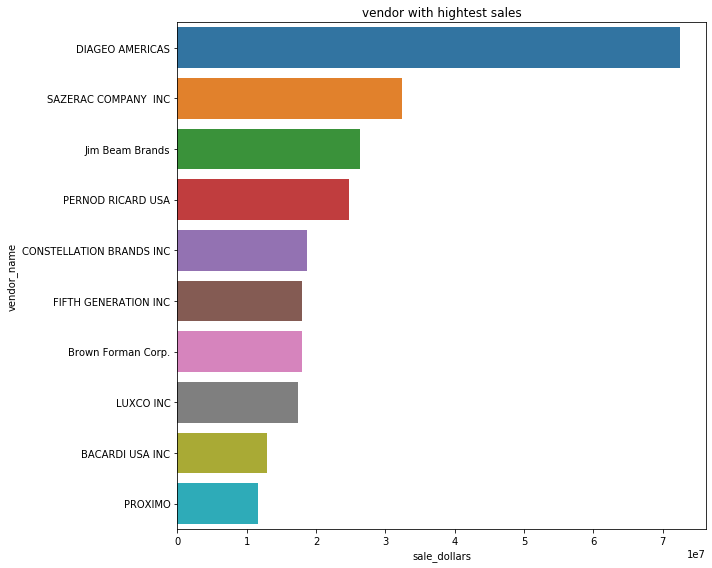

In [27]:
# Топ поставщики по суме продаж за год.
cats = df[["vendor_name", "sale_dollars"]].groupby("vendor_name").sum().sort_values(by="sale_dollars", ascending=False)[:10].reset_index()
plt.figure(figsize=(10,8))
sns.barplot(x="sale_dollars", y="vendor_name", data=cats)
plt.title('vendor with hightest sales')
plt.tight_layout()

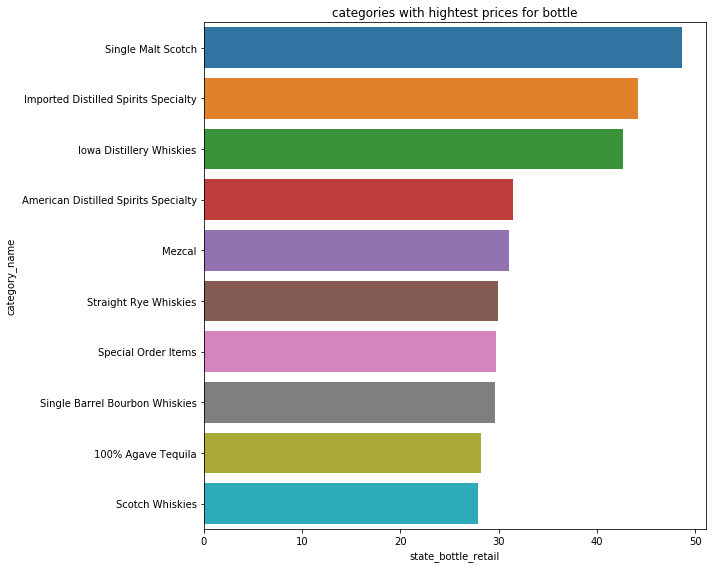

In [28]:
# Категории товара с самыми большими ценами за бутылку.
cats = df[["category_name", "state_bottle_retail"]].groupby("category_name").mean().sort_values(by="state_bottle_retail", ascending=False)[:10].reset_index()
plt.figure(figsize=(10,8))
sns.barplot(x="state_bottle_retail", y="category_name", data=cats)
plt.title('categories with hightest prices for bottle')
plt.tight_layout()